# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil, floor
from utils import line_draw, plot_img
import scipy

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [2]:

def apply_H(I, H):
     # Get the height and width of the input image
    rows, cols, channels = I.shape

    # Compute the corners of the input image
    corners = np.array([[0, 0, 1], [0, rows-1, 1], [cols-1, rows-1, 1], [cols-1, 0, 1]])
   
    # Transform the corners of the input image
    transformed_corners = np.dot(H, corners.T).T
    
    # Normalize the transformed corners
    transformed_corners = transformed_corners / transformed_corners[:, 2:]
    
    # Compute the bounding box of the transformed image
    min_x = int(np.floor(np.min(transformed_corners[:, 0])))
    max_x = int(np.ceil(np.max(transformed_corners[:, 0])))
    min_y = int(np.floor(np.min(transformed_corners[:, 1])))
    max_y = int(np.ceil(np.max(transformed_corners[:, 1])))
    
    # Create an empty output image with the size of the bounding box
    J = np.zeros((max_y - min_y + 1, max_x - min_x + 1, channels))

    #Compute the inverse of H 
    H = LA.inv(H)
    
    # Iterate over each pixel (i, j) in the output image
    for i in range(J.shape[0]):
        for j in range(J.shape[1]):
            # Compute the corresponding coordinates (x, y) in the input image
            x, y, w = np.dot(H, [j + min_x , i + min_y, 1])
            x, y = x/w, y/w
            
            # Check if the coordinates (x, y) are within the bounds of the input image
            if np.ceil(x) >= 0 and np.floor(x) < cols and np.ceil(y) >= 0 and np.floor(y) < rows:
                # If the coordinates are not integers, use interpolation with map_coordinates to get the pixel values from the input image
                if x != int(x) or y != int(y):
                    # Process each color channel separately
                    for c in range(channels):
                        J[i, j, c] = map_coordinates(I[:,:,c], [[y], [x]], order=1, cval=0)
                # If the coordinates are integers, use inverse warping to copy the pixel values from the input image to the output image
                else:
                    J[i, j] = I[int(y), int(x)]      
    
    # Return the output image
    return Image.fromarray(np.uint8(J))

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

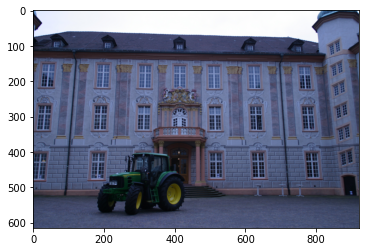

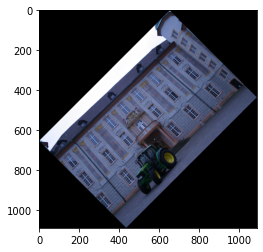

In [3]:

#4 degrees of freedom (1 scale, 1 angle, 2 translation)
def generate_similarity_transform(scale, angle, tx, ty):
  
  # Convert the angle to radians
  angle = np.radians(angle)
  
  # Compute the sine and cosine of the angle
  c, s = np.cos(angle), np.sin(angle)
  
  # Generate the affine transform matrix
  H = [[scale * c, -scale * s, tx],
       [scale * s, scale * c, ty],
       [0, 0, 1]]
  
  return H

H = generate_similarity_transform(1, -45, 0, 0) # the scale factor is 1 or -1 -> then it is isotropic


img_path = "./Data/0005_s.png"
I = Image.open(img_path)
I_sim = apply_H(np.array(I), H)
plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

Rotation 1: [[ 0.9701425   0.24253563  0.        ]
 [-0.24253563  0.9701425   0.        ]
 [ 0.          0.          1.        ]]
Rotation 2: [[ 0.61541221  0.78820544  0.        ]
 [-0.78820544  0.61541221  0.        ]
 [ 0.          0.          1.        ]]
Scale: [[1.28077641 0.         0.        ]
 [0.         0.78077641 0.        ]
 [0.         0.         1.        ]]
Translation: [[1. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
Original matrix: [[1.  0.5 1. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]
Reconstructed matrix: [[ 1.00000000e+00  5.00000000e-01  1.00000000e+00]
 [-9.00324979e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


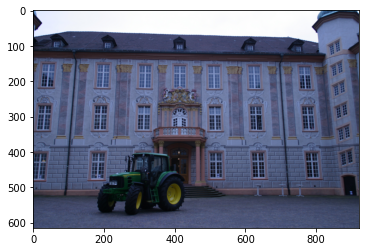

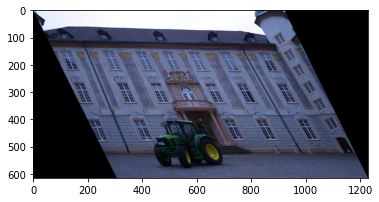

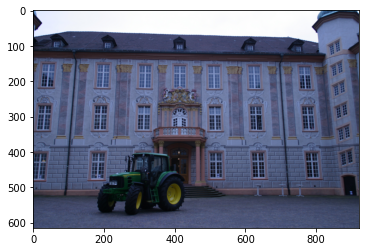

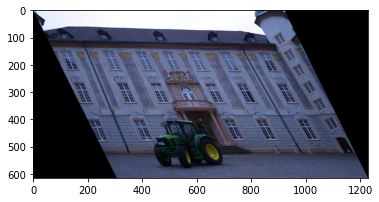

In [4]:
#6 degrees of freedom (2 scaling, 2 rotation angles, 2 translation)
def generate_affine_transform(a11, a12, a21, a22, tx, ty):

  # Generate A matrix
  
  # Generate the affine transform matrix
  H = [[a11, a12, tx],
       [a21, a22, ty],
       [0, 0, 1]]
       
  return H

H = generate_affine_transform(1, .5, 0 , 1, 1, 0) 
I_aff = apply_H(np.array(I), H)


plot_img(I)
plot_img(I_aff)
H = np.asarray(H)
#Extract the A matrix
A = H[:2, :2]

#Check if A is non-singular
if np.linalg.det(A) == 0:
    print("A is SINGULAR")
# Decompose the transformation matrix using SVD
U, D, V = np.linalg.svd(A)

#Create diagonal matrix with ones
ones = np.identity(3)
# Extract the rotation, scale, and translation components
rotation1 = np.copy(ones)
rotation1[:2, :2] = U @ V
scale =  np.copy(ones)
scale[:2,:2] = np.diag(D)
rotation2 = np.copy(ones)
rotation2[:2,:2] = V
translation = np.array([[1, 0,H[0][2]], [0, 1, H[1][2]], [0,0,1]])

print("Rotation 1:", rotation1)
print("Rotation 2:", rotation2)
print("Scale:", scale)
print("Translation:", translation)

# Reconstruct the original transformation matrix
H_reconstructed = translation @ rotation1 @ rotation2.T @ scale @ rotation2 

# Compare the original and reconstructed transformation matrices
print("Original matrix:", H)
print("Reconstructed matrix:", H_reconstructed)



plot_img(I)
plot_img(I_aff)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

[[1, 0.5, 10], [0, 1, 10], [0.001, 0.0015, 1]]


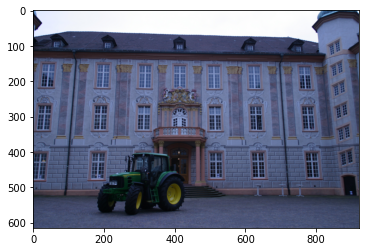

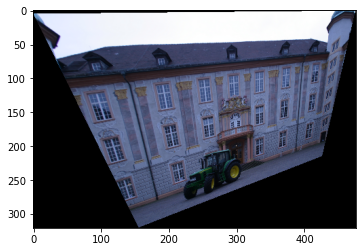

In [5]:
#8 degrees of freedom 
def generate_projective_transform(A, tx, ty, v1, v2):
  
  # Generate the projective transform matrix
  H = [[A[0][0], A[0][1], tx],
  [A[1][0], A[1][1], ty],
  [v1, v2, 1]]
  
  return H

A = [[1,.5], [0,1]]
tx = 10
ty = 10
v1 = .001
v2 = .0015
H = generate_projective_transform(A, tx, ty, v1, v2) # the scale factor is 1 or -1 -> then it is isotropic
print(H)
if np.linalg.det(H) != 0:
  I_proj = apply_H(np.array(I), H)
else:
  print("Matrix is singular")

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [6]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [7]:
def line_from_points(p1, p2):
  # Compute cross product between p1 and p2
  c = np.cross(p1, p2)

  # Return the line in the form [a, b, c]
  return c

l1 = line_from_points(p1,p2)# complete ...
l2 = line_from_points(p3,p4)
l3 = line_from_points(p5,p6)
l4 = line_from_points(p7,p8)

  


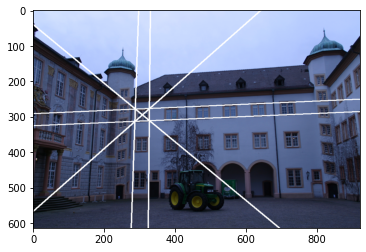

In [8]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size) #top horizontal line
line_draw(l2, canv, I.size) #bottom horizontal line
line_draw(l3, canv, I.size) #left vertical line
line_draw(l4, canv, I.size) #right vertical line

def diagonal_lines_from_hor_ver(l1, l2, l3, l4):
  int_top_left = np.cross(l1, l3)
  int_top_right = np.cross(l1, l4)
  int_bottom_left = np.cross(l2, l3)
  int_bottom_right = np.cross(l2, l4)

  diag1 = np.cross(int_top_left,int_bottom_right)
  diag2 = np.cross(int_top_right,int_bottom_left)
  return diag1, diag2

diag1, diag2 = diagonal_lines_from_hor_ver(l1, l2, l3, l4)
line_draw(diag1, canv, I.size) 
line_draw(diag2, canv, I.size) 

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

85.45401946339824 72.64082077686572
93.10326162848753 107.35917922313428


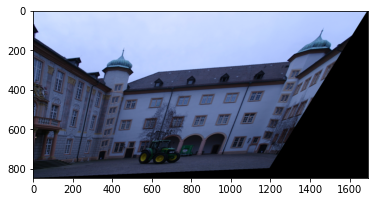

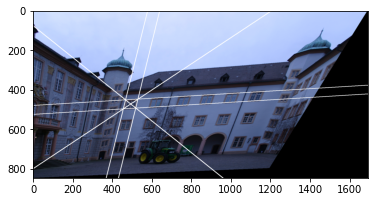

In [9]:
#Compute the vanishing point from the cross product
vanishing_point1 = np.cross(l1,l2)
vanishing_point2 = np.cross(l3,l4)


#Compute the vanishing line
vanishing_line = line_from_points(vanishing_point1, vanishing_point2)
vanishing_line = vanishing_line / vanishing_line[2]
#Compute H
Ha = np.asarray([[2, 0, 0], [0, 2, 0], [vanishing_line[0], vanishing_line[1], vanishing_line[2]]])

#Transformed image
I_transformed = apply_H(np.array(I), Ha)
plot_img(I_transformed)
#Transformed lines
transformed_l1 = np.matmul(l1, LA.inv(Ha))
transformed_l2 = np.matmul(l2, LA.inv(Ha))
transformed_l3 = np.matmul(l3, LA.inv(Ha))
transformed_l4 = np.matmul(l4, LA.inv(Ha))

# lr1 and lr2 are orthogonal w.r.t lr3 and lr4, but lr1 and lr2 are parallel
transformed_diag1, transformed_diag2 = diagonal_lines_from_hor_ver(transformed_l1, transformed_l2, transformed_l3, transformed_l4)
# show the transformed lines in the image
canv = ImageDraw.Draw(I_transformed)
point_color = (0, 0, 255)
line_draw(transformed_l1, canv, I_transformed.size)
line_draw(transformed_l2, canv, I_transformed.size)
line_draw(transformed_l3, canv, I_transformed.size)
line_draw(transformed_l4, canv, I_transformed.size)
line_draw(transformed_diag1, canv, I_transformed.size)
line_draw(transformed_diag2, canv, I_transformed.size)

plot_img(I_transformed)
I = Image.open(img_path)
#Compute angles between pair of lines
def angle_between_lines(line1, line2):
  #Define the dual conic
  C_inf = np.asarray([[1,0,0],[0,1,0],[0,0,0]])
  
  # Compute the angle between the lines using the dual conic
  numerator = np.dot(np.dot(line1.T, C_inf), line2)
  denominator = np.sqrt(
                      np.dot(
                        np.dot(
                          np.dot(line1.T, C_inf), line1),
                        np.dot(
                          np.dot(line2.T, C_inf), line2)
                        )
                      )
  
  angle = np.arccos(float(numerator) / float(denominator))
  
  return np.degrees(angle)

angle_l1_l2 = angle_between_lines(l1, l3)
angle_l3_l4 = angle_between_lines(l2, l4)
angle_transformed_l1_l2 = angle_between_lines(transformed_l1, transformed_l3)
angle_transformed_l3_l4 = angle_between_lines(transformed_l2, transformed_l4)

print(angle_l1_l2, angle_transformed_l1_l2)
print(angle_l3_l4, angle_transformed_l3_l4)

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


[[ 0.88227688]
 [-0.16045754]
 [ 0.44253913]]
[[0.8822768833089784, -0.16045753708685606], [-0.16045753708685606, 0.4425391281803399]]
[[ 0.93929595  0.        ]
 [-0.17082746  0.64292854]]
85.45401946339824 90.00000000000001
93.10326162848753 90.0


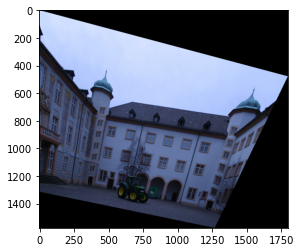

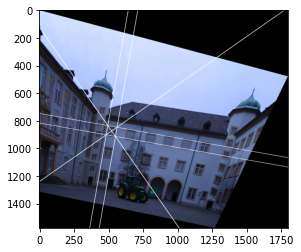

In [10]:
#Solve S -> (l1'm1', l1'm2' + l2'm1', l2'm2')(s11,s12, s22)^T = 0 to obtain K
#I_transformed = apply_H(np.array(I), H)
transformed_l2 = transformed_diag1
transformed_l4 = transformed_diag2
#Create matrix S
a = np.asarray([transformed_l1[0]*transformed_l3[0], 
                 transformed_l1[0]*transformed_l3[1] + transformed_l1[1]*transformed_l3[0],
                transformed_l1[1]*transformed_l3[1]])

b = np.asarray([transformed_l2[0]*transformed_l4[0], 
                 transformed_l2[0]*transformed_l4[1] + transformed_l2[1]*transformed_l4[0],
                transformed_l2[1]*transformed_l4[1]])

S = np.asarray([a, b])

#Solve the system
#_ , _ , v = np.linalg.svd(S)
#print(v)
#E = v[:, -1]


def null_space(A, rcond=None):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

S = scipy.linalg.null_space(S, np.array([0,0]))
print(S)
#Compose matrix S with values [s1, s2, s2, s3]
S = [[S[0,0], S[1,0]], [S[1,0], S[2,0]]]
print(S)
#Cholesky decomposition
K = np.linalg.cholesky(S)
K_inv = np.linalg.inv(K)
print(K)
#U,D,V = np.linalg.svd(S)



#A = U @ np.sqrt(D) @ V.T
Hm = np.identity(3)

Hm[0,0] = K_inv[0,0]
Hm[0,1] = K_inv[0,1]
Hm[1,0] = K_inv[1,0]
Hm[1,1] = K_inv[1,1]

H = Hm @ Ha
I_metric = apply_H(np.array(I), H)

plot_img(I_metric)

#Transformed lines
transformed_l1_metric = np.matmul(l1, LA.inv(H))
transformed_l2_metric = np.matmul(l2, LA.inv(H))
transformed_l3_metric = np.matmul(l3, LA.inv(H))
transformed_l4_metric = np.matmul(l4, LA.inv(H))
transformed_d1_metric = np.matmul(diag1, LA.inv(H))
transformed_d2_metric = np.matmul(diag2, LA.inv(H))

# show the transformed lines in the image
canv = ImageDraw.Draw(I_metric)
point_color = (0, 0, 255)
line_draw(transformed_l1_metric, canv, I_metric.size)
line_draw(transformed_l2_metric, canv, I_metric.size)
line_draw(transformed_l3_metric, canv, I_metric.size)
line_draw(transformed_l4_metric, canv, I_metric.size)
line_draw(transformed_d1_metric, canv, I_metric.size)
line_draw(transformed_d2_metric, canv, I_metric.size)

plot_img(I_metric)

#Compute angles between pair of lines

angle_l1_l2 = angle_between_lines(l1, l3)
angle_l3_l4 = angle_between_lines(l2, l4)
angle_transformed_metric_l1_l2 = angle_between_lines(transformed_l1_metric, transformed_l3_metric)
angle_transformed_metric_l3_l4 = angle_between_lines(transformed_l2_metric, transformed_l4_metric)

print(angle_l1_l2, angle_transformed_metric_l1_l2)
print(angle_l3_l4, angle_transformed_metric_l3_l4)


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

67.73232008108977 66.17504650222577
72.27806605501624 66.17504650222578


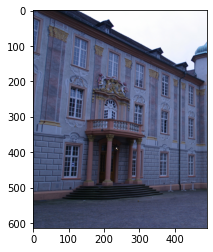

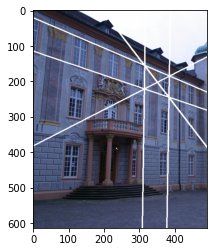

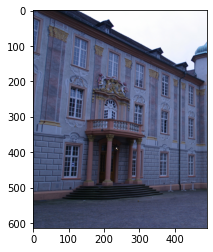

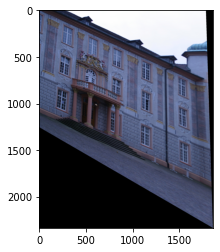

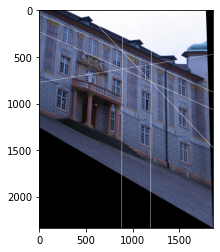

In [17]:
# load images and lines
img_path = "./Data/0001_s.png"
I = Image.open(img_path)

lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 613 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 158
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 644
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 540
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

l1 = line_from_points(p1,p2)
l2 = line_from_points(p3,p4)
l3 = line_from_points(p5,p6)
l4 = line_from_points(p7,p8)
# show the chosen lines in the image
I_lines = I.copy()
# show the chosen lines in the image
canv = ImageDraw.Draw(I_lines)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size) #top horizontal line
line_draw(l2, canv, I.size) #bottom horizontal line
line_draw(l3, canv, I.size) #left vertical line
line_draw(l4, canv, I.size) #right vertical line

def diagonal_lines_from_hor_ver(l1, l2, l3, l4):
  int_top_left = np.cross(l1, l3)
  int_top_right = np.cross(l1, l4)
  int_bottom_left = np.cross(l2, l3)
  int_bottom_right = np.cross(l2, l4)

  diag1 = np.cross(int_top_left,int_bottom_right)
  diag2 = np.cross(int_top_right,int_bottom_left)
  return diag1, diag2

diag1, diag2 = diagonal_lines_from_hor_ver(l1, l2, l3, l4)
line_draw(diag1, canv, I.size) 
line_draw(diag2, canv, I.size) 
I = np.array(I)[:,:490]
I_lines = np.array(I_lines)[:,:490]
plot_img(I)
plot_img(I_lines)
# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
#Compute the vanishing point from the cross product
vanishing_point1 = np.cross(l1,l2)
vanishing_point2 = np.cross(l3,l4)
#import sys
#sys.exit()

#Compute the vanishing line
vanishing_line = line_from_points(vanishing_point1, vanishing_point2)
vanishing_line = vanishing_line / vanishing_line[2]
#Compute H
Ha = np.asarray([[2, 0, 0], [0, 2, 0], [vanishing_line[0], vanishing_line[1], vanishing_line[2]]])

#Transformed image
I_transformed = apply_H(np.array(I), Ha)
plot_img(I_transformed)
#Transformed lines
transformed_l1 = np.matmul(l1, LA.inv(Ha))
transformed_l2 = np.matmul(l2, LA.inv(Ha))
transformed_l3 = np.matmul(l3, LA.inv(Ha))
transformed_l4 = np.matmul(l4, LA.inv(Ha))

# lr1 and lr2 are orthogonal w.r.t lr3 and lr4, but lr1 and lr2 are parallel
transformed_diag1, transformed_diag2 = diagonal_lines_from_hor_ver(transformed_l1, transformed_l2, transformed_l3, transformed_l4)
# show the transformed lines in the image
canv = ImageDraw.Draw(I_transformed)
point_color = (0, 0, 255)
line_draw(transformed_l1, canv, I_transformed.size)
line_draw(transformed_l2, canv, I_transformed.size)
line_draw(transformed_l3, canv, I_transformed.size)
line_draw(transformed_l4, canv, I_transformed.size)
line_draw(transformed_diag1, canv, I_transformed.size)
line_draw(transformed_diag2, canv, I_transformed.size)

plot_img(I_transformed)
I = Image.open(img_path)
#Compute angles between pair of lines
def angle_between_lines(line1, line2):
  #Define the dual conic
  C_inf = np.asarray([[1,0,0],[0,1,0],[0,0,0]])
  
  # Compute the angle between the lines using the dual conic
  numerator = np.dot(np.dot(line1.T, C_inf), line2)
  denominator = np.sqrt(
                      np.dot(
                        np.dot(
                          np.dot(line1.T, C_inf), line1),
                        np.dot(
                          np.dot(line2.T, C_inf), line2)
                        )
                      )
  
  angle = np.arccos(float(numerator) / float(denominator))
  
  return np.degrees(angle)

angle_l1_l2 = angle_between_lines(l1, l3)
angle_l3_l4 = angle_between_lines(l2, l4)
angle_transformed_l1_l2 = angle_between_lines(transformed_l1, transformed_l3)
angle_transformed_l3_l4 = angle_between_lines(transformed_l2, transformed_l4)

print(angle_l1_l2, angle_transformed_l1_l2)
print(angle_l3_l4, angle_transformed_l3_l4)

In [ ]:
#Solve S -> (l1'm1', l1'm2' + l2'm1', l2'm2')(s11,s12, s22)^T = 0 to obtain K
#I_transformed = apply_H(np.array(I), H)
transformed_l2 = transformed_diag1
transformed_l4 = transformed_diag2
#Create matrix S
a = np.asarray([transformed_l1[0]*transformed_l3[0], 
                 transformed_l1[0]*transformed_l3[1] + transformed_l1[1]*transformed_l3[0],
                transformed_l1[1]*transformed_l3[1]])

b = np.asarray([transformed_l2[0]*transformed_l4[0], 
                 transformed_l2[0]*transformed_l4[1] + transformed_l2[1]*transformed_l4[0],
                transformed_l2[1]*transformed_l4[1]])

S = np.asarray([a, b])

#Solve the system
#_ , _ , v = np.linalg.svd(S)
#print(v)
#E = v[:, -1]


def null_space(A, rcond=None):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

S = scipy.linalg.null_space(S, np.array([0,0]))
print(S)
#Compose matrix S with values [s1, s2, s2, s3]
S = [[S[0,0], S[1,0]], [S[1,0], S[2,0]]]
print(S)
#Cholesky decomposition
K = np.linalg.cholesky(S)
K_inv = np.linalg.inv(K)
print(K)
#U,D,V = np.linalg.svd(S)



#A = U @ np.sqrt(D) @ V.T
Hm = np.identity(3)

Hm[0,0] = K_inv[0,0]
Hm[0,1] = K_inv[0,1]
Hm[1,0] = K_inv[1,0]
Hm[1,1] = K_inv[1,1]

H = Hm @ Ha
I_metric = apply_H(np.array(I), H)

plot_img(I_metric)

#Transformed lines
transformed_l1_metric = np.matmul(l1, LA.inv(H))
transformed_l2_metric = np.matmul(l2, LA.inv(H))
transformed_l3_metric = np.matmul(l3, LA.inv(H))
transformed_l4_metric = np.matmul(l4, LA.inv(H))
transformed_d1_metric = np.matmul(diag1, LA.inv(H))
transformed_d2_metric = np.matmul(diag2, LA.inv(H))

# show the transformed lines in the image
canv = ImageDraw.Draw(I_metric)
point_color = (0, 0, 255)
line_draw(transformed_l1_metric, canv, I_metric.size)
line_draw(transformed_l2_metric, canv, I_metric.size)
line_draw(transformed_l3_metric, canv, I_metric.size)
line_draw(transformed_l4_metric, canv, I_metric.size)
line_draw(transformed_d1_metric, canv, I_metric.size)
line_draw(transformed_d2_metric, canv, I_metric.size)

plot_img(I_metric)

#Compute angles between pair of lines

angle_l1_l2 = angle_between_lines(l1, l3)
angle_l3_l4 = angle_between_lines(l2, l4)
angle_transformed_metric_l1_l2 = angle_between_lines(transformed_l1_metric, transformed_l3_metric)
angle_transformed_metric_l3_l4 = angle_between_lines(transformed_l2_metric, transformed_l4_metric)

print(angle_l1_l2, angle_transformed_metric_l1_l2)
print(angle_l3_l4, angle_transformed_metric_l3_l4)

[[0.80952602]
 [0.36086119]
 [0.46308404]]
[[0.809526020937227, 0.36086118655192523], [0.36086118655192523, 0.4630840371529523]]
[[0.89973664 0.        ]
 [0.40107424 0.54974857]]
